# 🐝🎵 Introduction to Xylo™Audio

> **_Note:_** In this tutorial Xylo™Audio refers to Xylo™Audio 2 and Xylo™Audio 3. In case differences occur we will explicitly name the correct HDK.

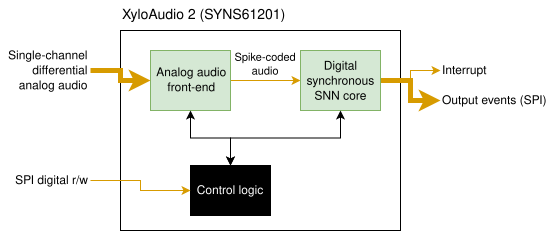

In [8]:
# - Display images
from IPython.display import Image

Image('xylo-a2-block-level.png')

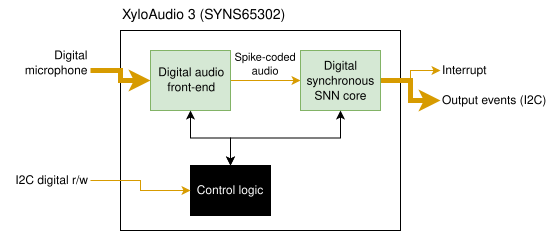

In [6]:
# - Display images
from IPython.display import Image

Image('xylo-a3-block-level.png')

## Part I: Using the XyloAudio SNN Core

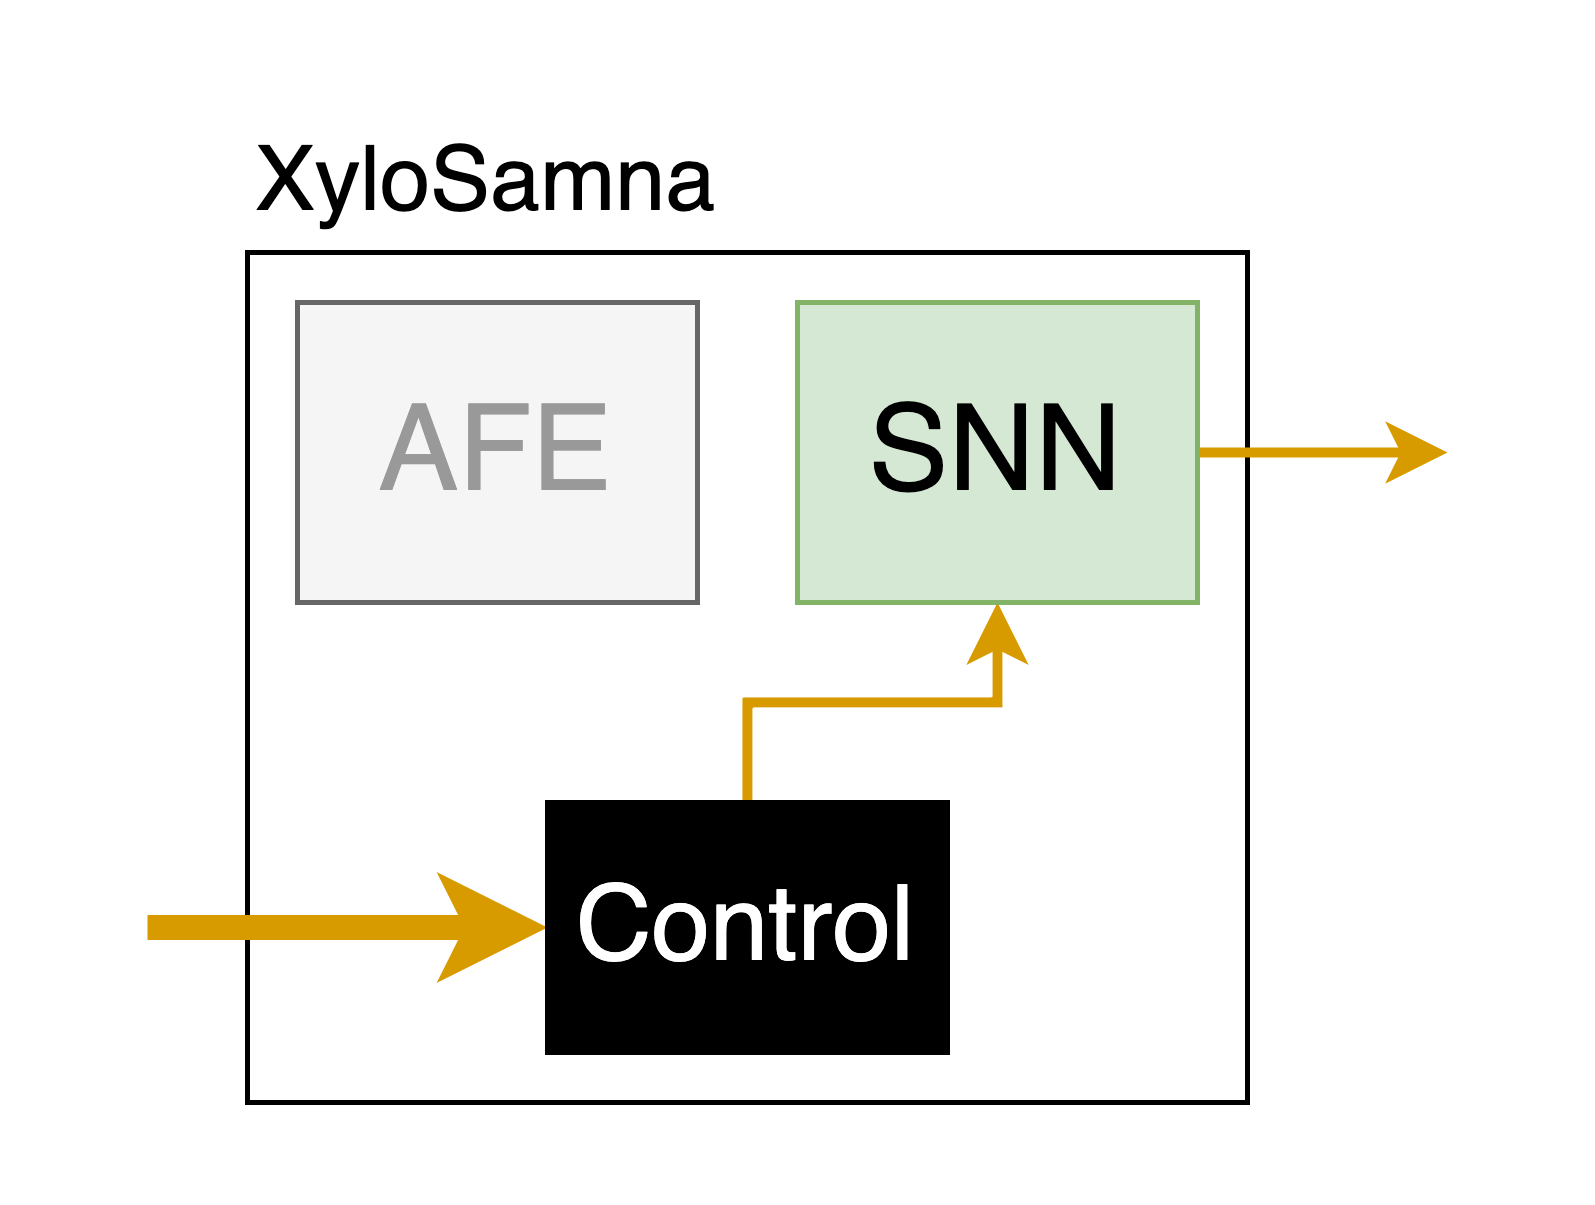

In [2]:
Image('XyloSamna.png', width=400)

### Step 1: Build a network in rockpool and convert it to a hardware configuration

In [3]:
# - Import the computational modules and combinators required for the network
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual
from rockpool.transform import quantize_methods as q
from rockpool import TSEvent, TSContinuous

# - Imports dependent on your HDK
# - XyloAudio 2
import rockpool.devices.xylo.syns61201 as xa2
from rockpool.devices.xylo.syns61201 import xa2_devkit_utils as xa2utils
# - XyloAudio 3
# import rockpool.devices.xylo.syns65302 as xa3
# from rockpool.devices.xylo.syns65302 import xa3_devkit_utils as xa3utils

import numpy as np

try:
    from rich import print
except:
    pass

import sys
!{sys.executable} -m pip install --quiet matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

# - Disable warnings
import warnings
warnings.filterwarnings('ignore')

from IPython import display

In [4]:
# - Define the size of the network layers
Nin = 2
Nhidden = 4
Nout = 2
dt = 1e-3

In [5]:
# - Define the network architecture using combinators and modules
net = Sequential(
    LinearTorch((Nin, Nhidden), has_bias = False),
    LIFTorch(Nhidden, dt = dt),
    
    Residual(
        LinearTorch((Nhidden, Nhidden), has_bias = False),
        LIFTorch(Nhidden, has_rec = True, threshold = 1., dt = dt),
    ),
    
    LinearTorch((Nhidden, Nout), has_bias = False),
    LIFTorch(Nout, dt = dt),
)
print(net)

# - Scale down recurrent weights for stability
# net[2][1].w_rec.data = net[2][1].w_rec / 10.

TorchSequential  with shape (2, 2) {
    LinearTorch '0_LinearTorch' with shape (2, 4)
    LIFTorch '1_LIFTorch' with shape (4, 4)
    TorchResidual '2_TorchResidual' with shape (4, 4) {
        LinearTorch '0_LinearTorch' with shape (4, 4)
        LIFTorch '1_LIFTorch' with shape (4, 4)
    }
    LinearTorch '3_LinearTorch' with shape (4, 2)
    LIFTorch '4_LIFTorch' with shape (2, 2)
}

In [7]:
# - Call the Xylo mapper on the extracted computational graph
# - For XyloAudio 2
spec = xa2.mapper(net.as_graph(),  weight_dtype='float', threshold_dtype='float', dash_dtype='float')
# - For XyloAudio 3
# spec = xa3.mapper(net.as_graph(),  weight_dtype='float', threshold_dtype='float', dash_dtype='float')

# - Quantize the specification
spec.update(q.global_quantize(**spec))

# # you can also try channel-wise quantization
# spec.update(q.channel_quantize(**spec))
# print(spec)

# - Use rockpool.devices.xylo.config_from_specification to convert it to a hardware configuration
# - For XyloAudio 2
config, is_valid, msg = xa2.config_from_specification(**spec)
# - For XyloAudio 3
# config, is_valid, msg = xa3.config_from_specification(**spec)

if not is_valid:
    print(msg)

In [8]:
# - Use rockpool.devices.xylo.find_xylo_hdks to connect to an HDK
from rockpool.devices.xylo import find_xylo_hdks
xylo_hdk_nodes, modules, versions = find_xylo_hdks()
print(versions)

hdk = None

for version, xylo in zip(versions, xylo_hdk_nodes):
    if version == "syns61201":
        hdk = xylo
    # - For XyloAudio 3
    # if version == "syns65302":
    #     hdk = xylo

if hdk is None:
    assert False, 'This tutorial requires a connected XyloAudio HDK to demonstrate.'


The connected Xylo HDK contains a Xylo Audio v2 (SYNS61201). Importing `rockpool.devices.xylo.syns61201`


['syns61201']

In [9]:
# - Use XyloSamna to deploy to the HDK
if hdk:
    # - For XyloAudio 2
    modSamna = xa2.XyloSamna(hdk, config, dt = dt) 
    # - For XyloAudio 3
    # modSamna = xa3.XyloSamna(hdk, config, dt = dt) 

print(modSamna)

XyloSamna  with shape (2, 8, 2)

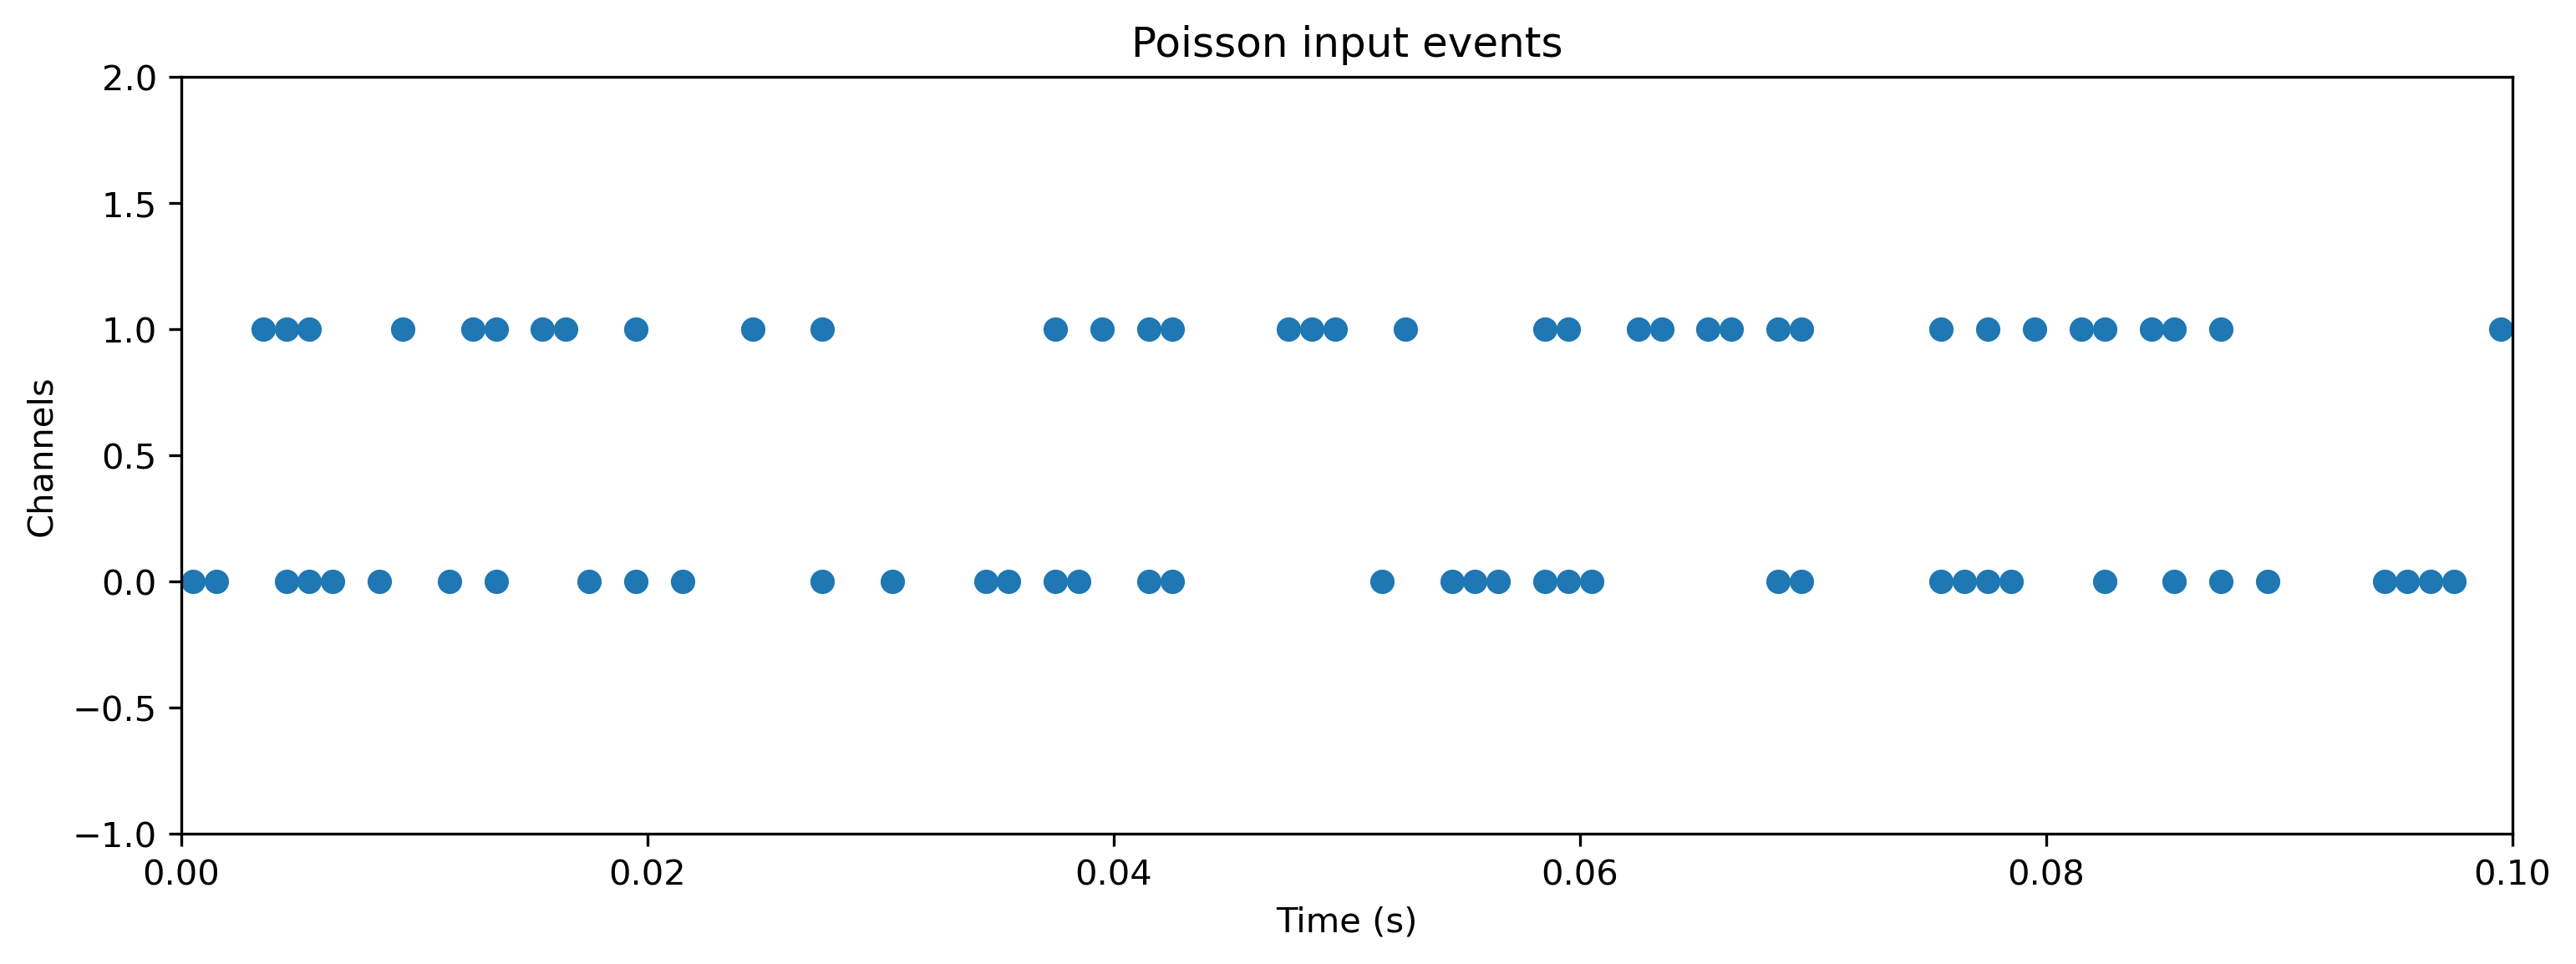

In [10]:
# - Generate some Poisson input
T = 100
f = 0.4
input_spikes = np.random.rand(T, Nin) < f
TSEvent.from_raster(input_spikes, dt, name = 'Poisson input events').plot();

In [11]:
# - Evolve the network on the Xylo HDK
# - `reset_state` is only needed for XyloAudio 2
modSamna.reset_state()
out, _, r_d = modSamna(input_spikes, record = True)

# - Show the internal state variables recorded 
print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Isyn2', 'Spikes', 'Vmem_out', 'Isyn_out', 'times'])

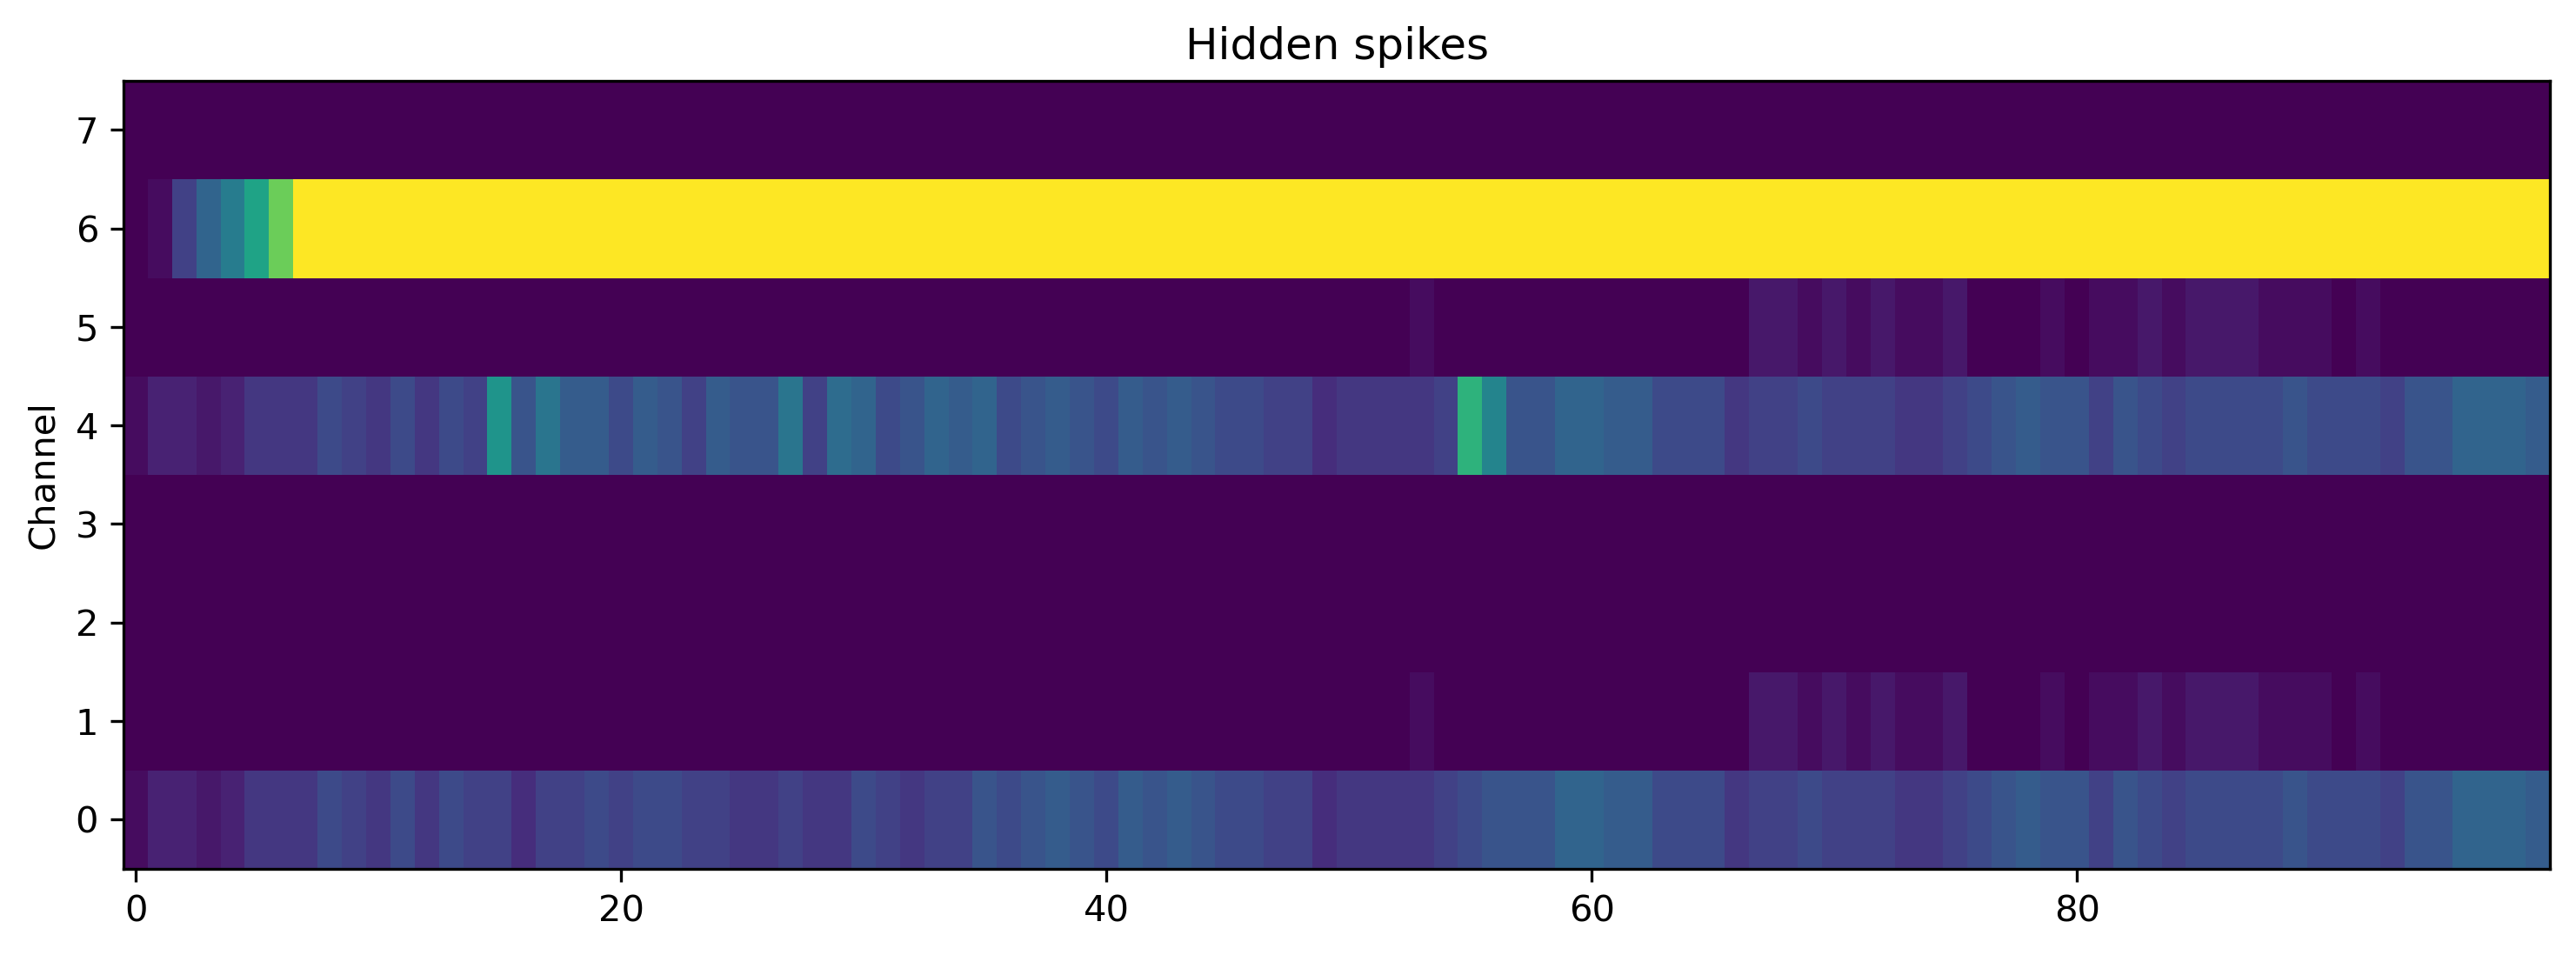

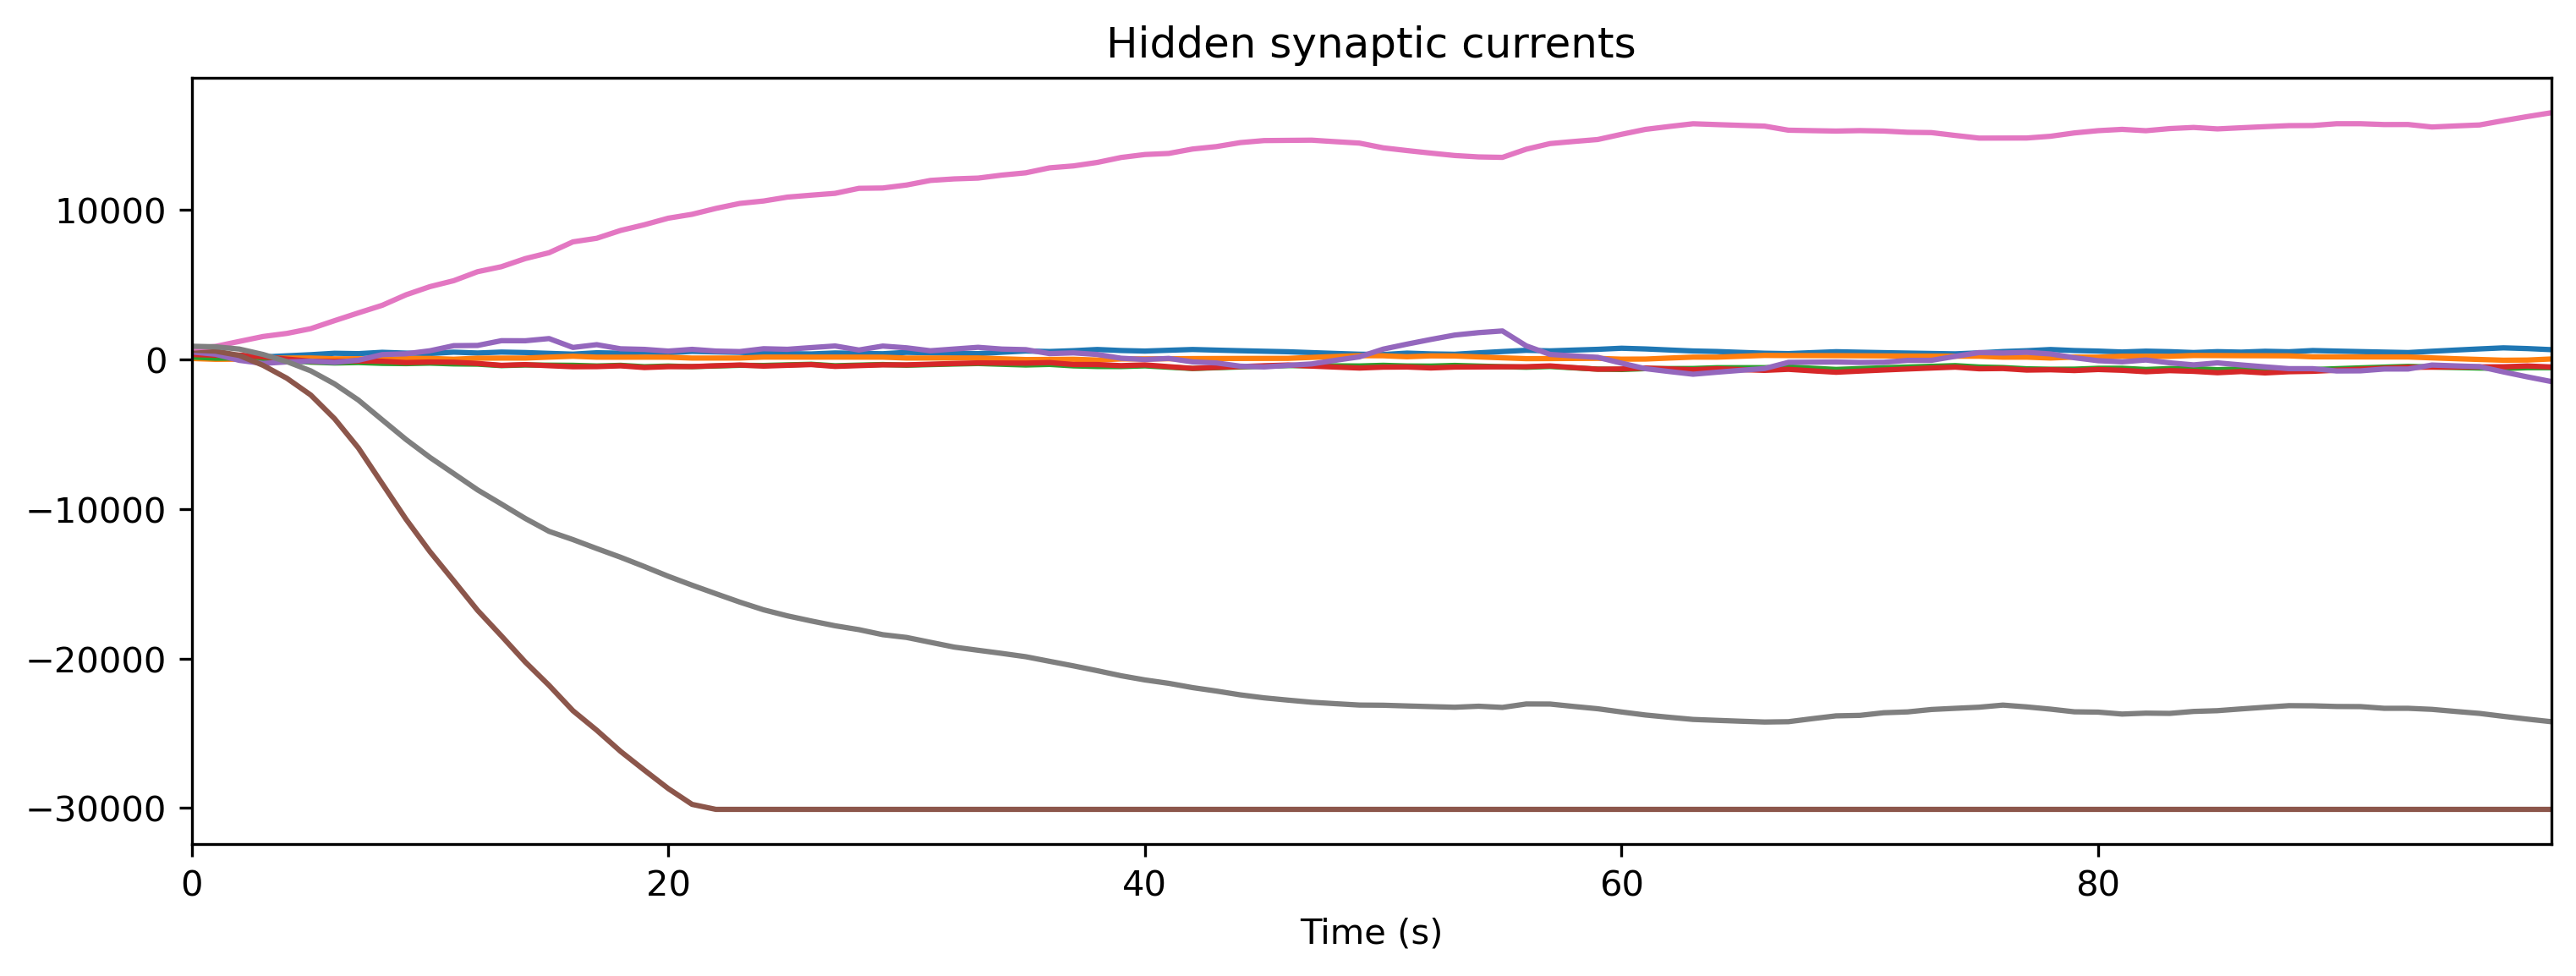

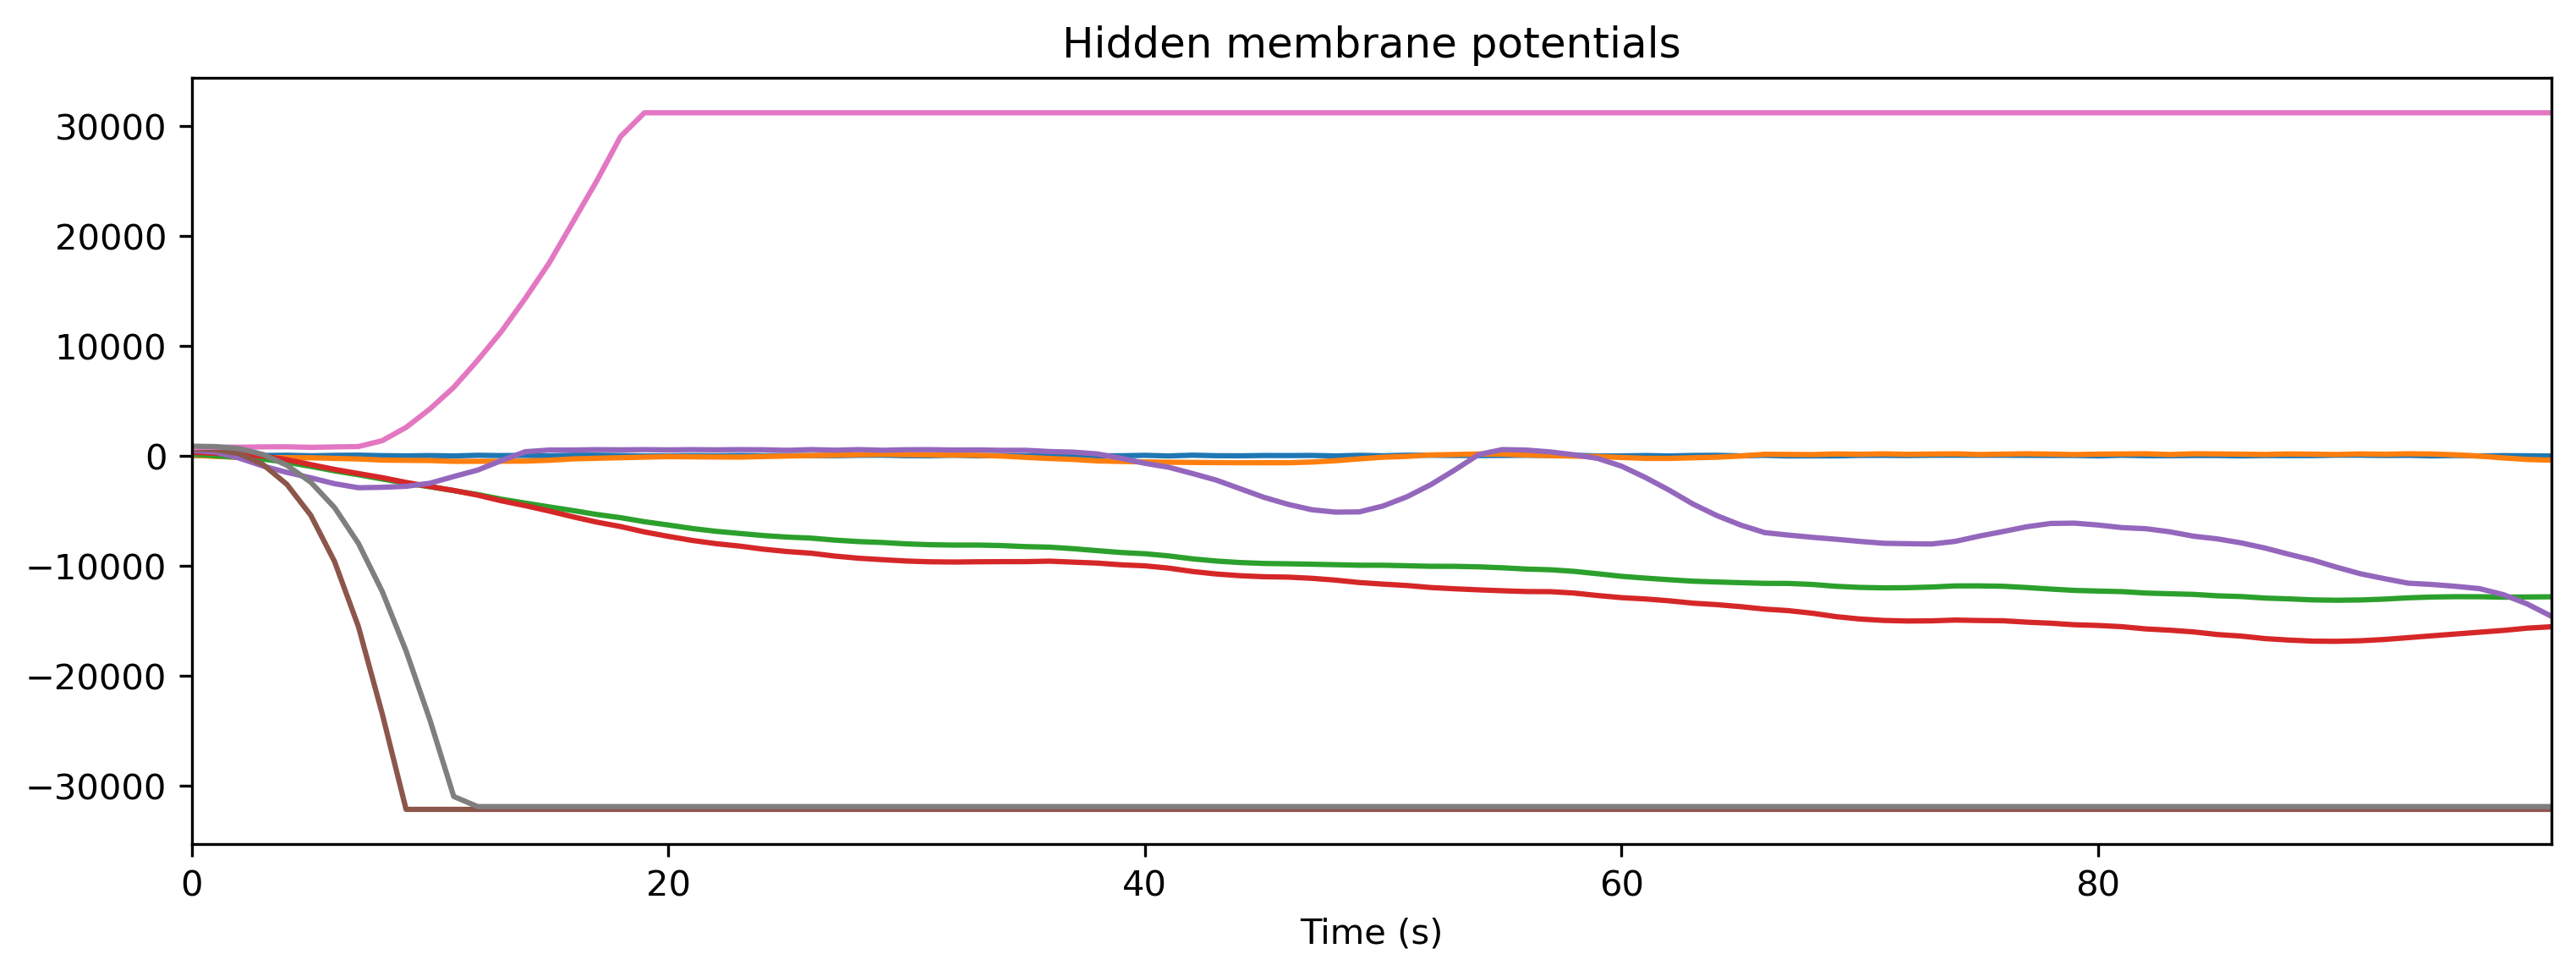

In [12]:
# - Plot some internal state variables
plt.figure()
plt.imshow(r_d['Spikes'].T, aspect = 'auto', origin = 'lower')
plt.title('Hidden spikes')
plt.ylabel('Channel')

plt.figure()
TSContinuous(r_d['times'], r_d['Isyn'], name = 'Hidden synaptic currents').plot(stagger = 127)

plt.figure()
TSContinuous(r_d['times'], r_d['Vmem'], name = 'Hidden membrane potentials').plot(stagger = 127);

### Step 3: Simulate the HDK using the `XyloSim` bit-precise simulator

In [13]:
# - Configure the simulator with the HW network config
# - For XyloAudio 2
modSim = xa2.XyloSim.from_config(config, dt=dt)
# - For XyloAudio 3
# modSim = xa3.XyloSim.from_config(config, dt=dt)

print(modSim)

XyloSim  with shape (16, 1000, 8)

In [14]:
# - Evolve the input over the network, in simulation
out, _, r_d = modSim(input_spikes, record = True)

# - Show the internal state variables recorded 
print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Isyn2', 'Spikes', 'Vmem_out', 'Isyn_out'])

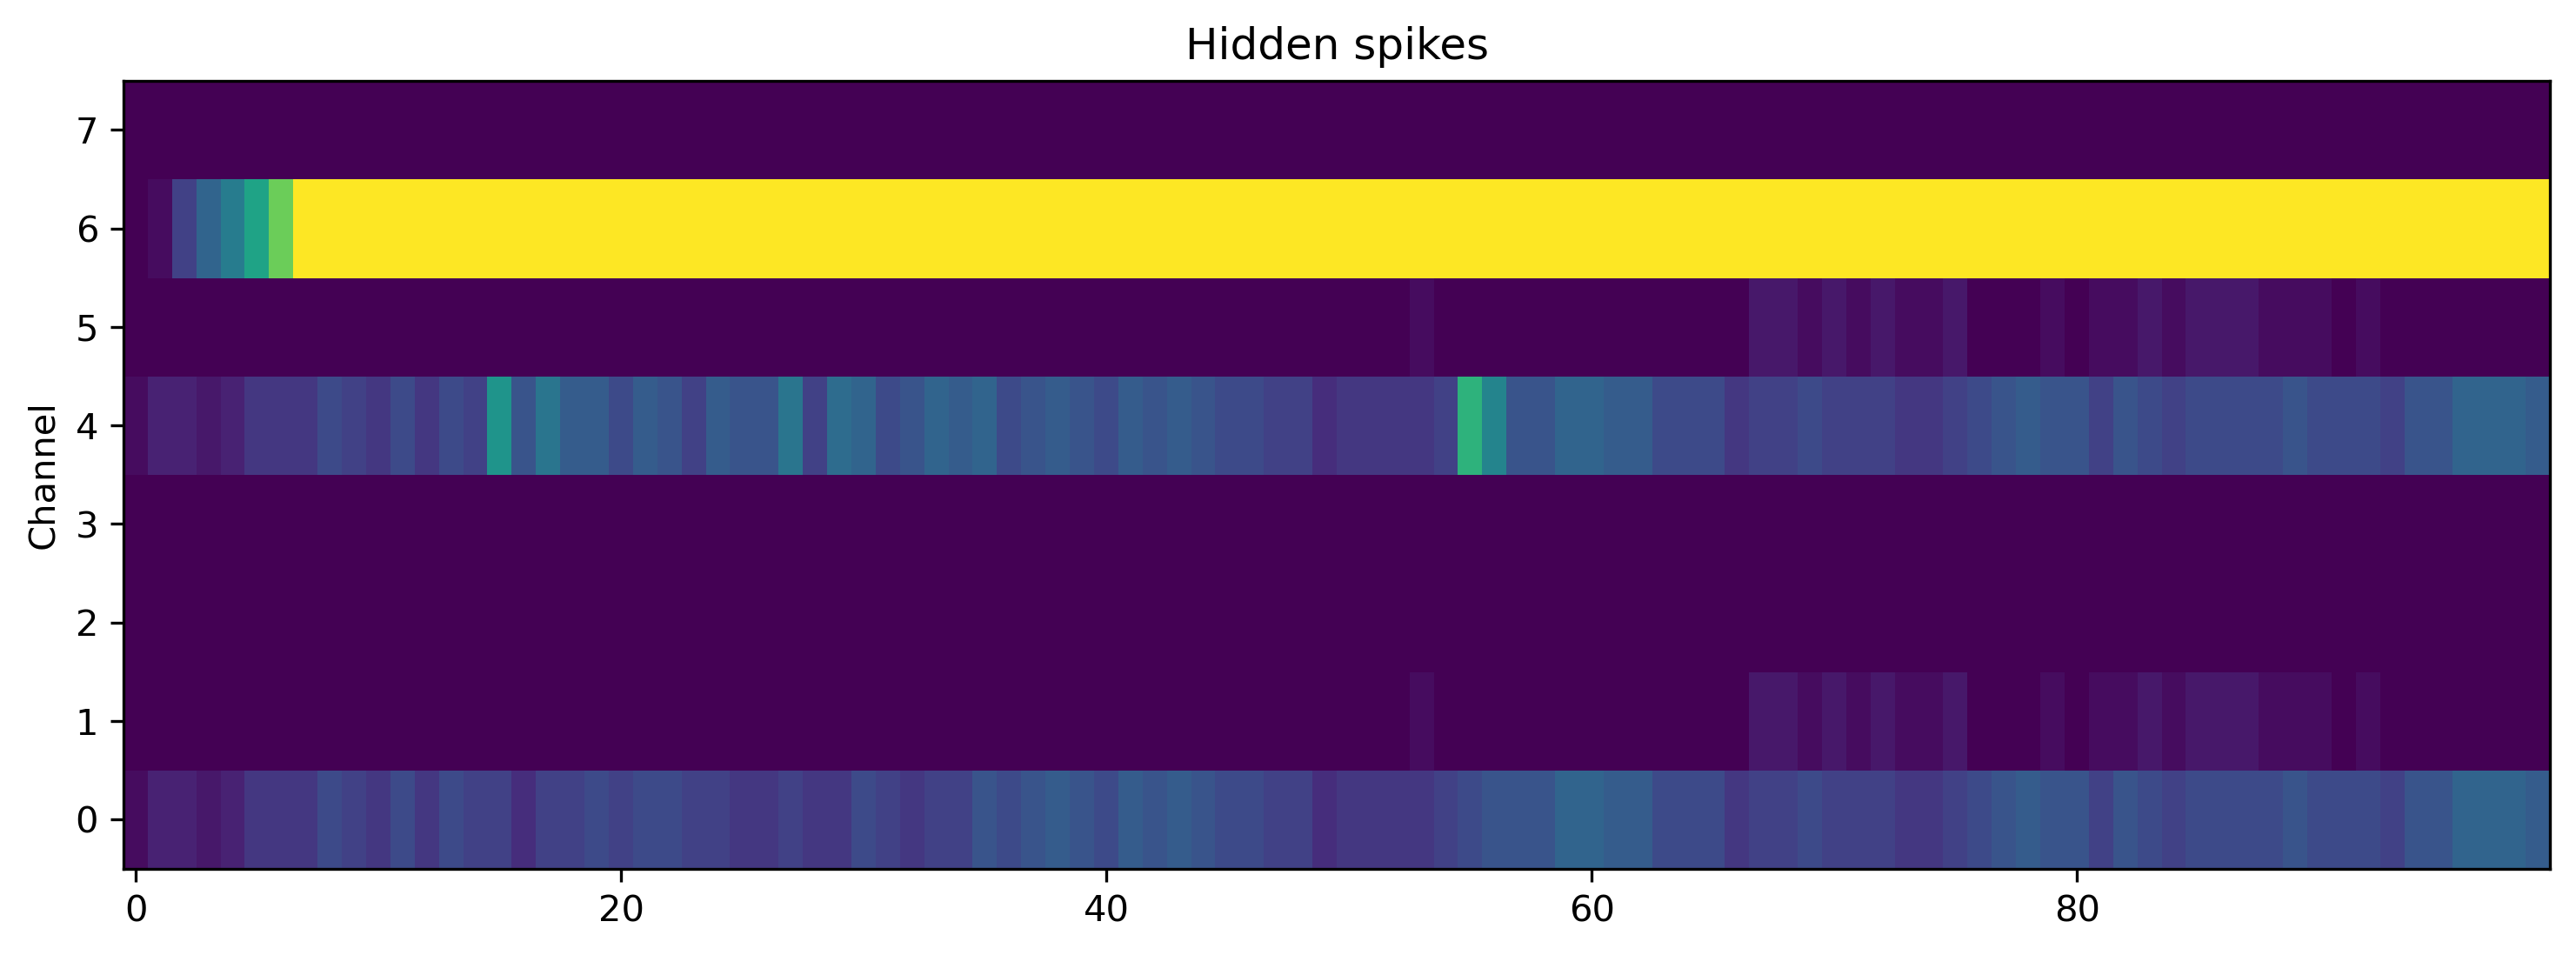

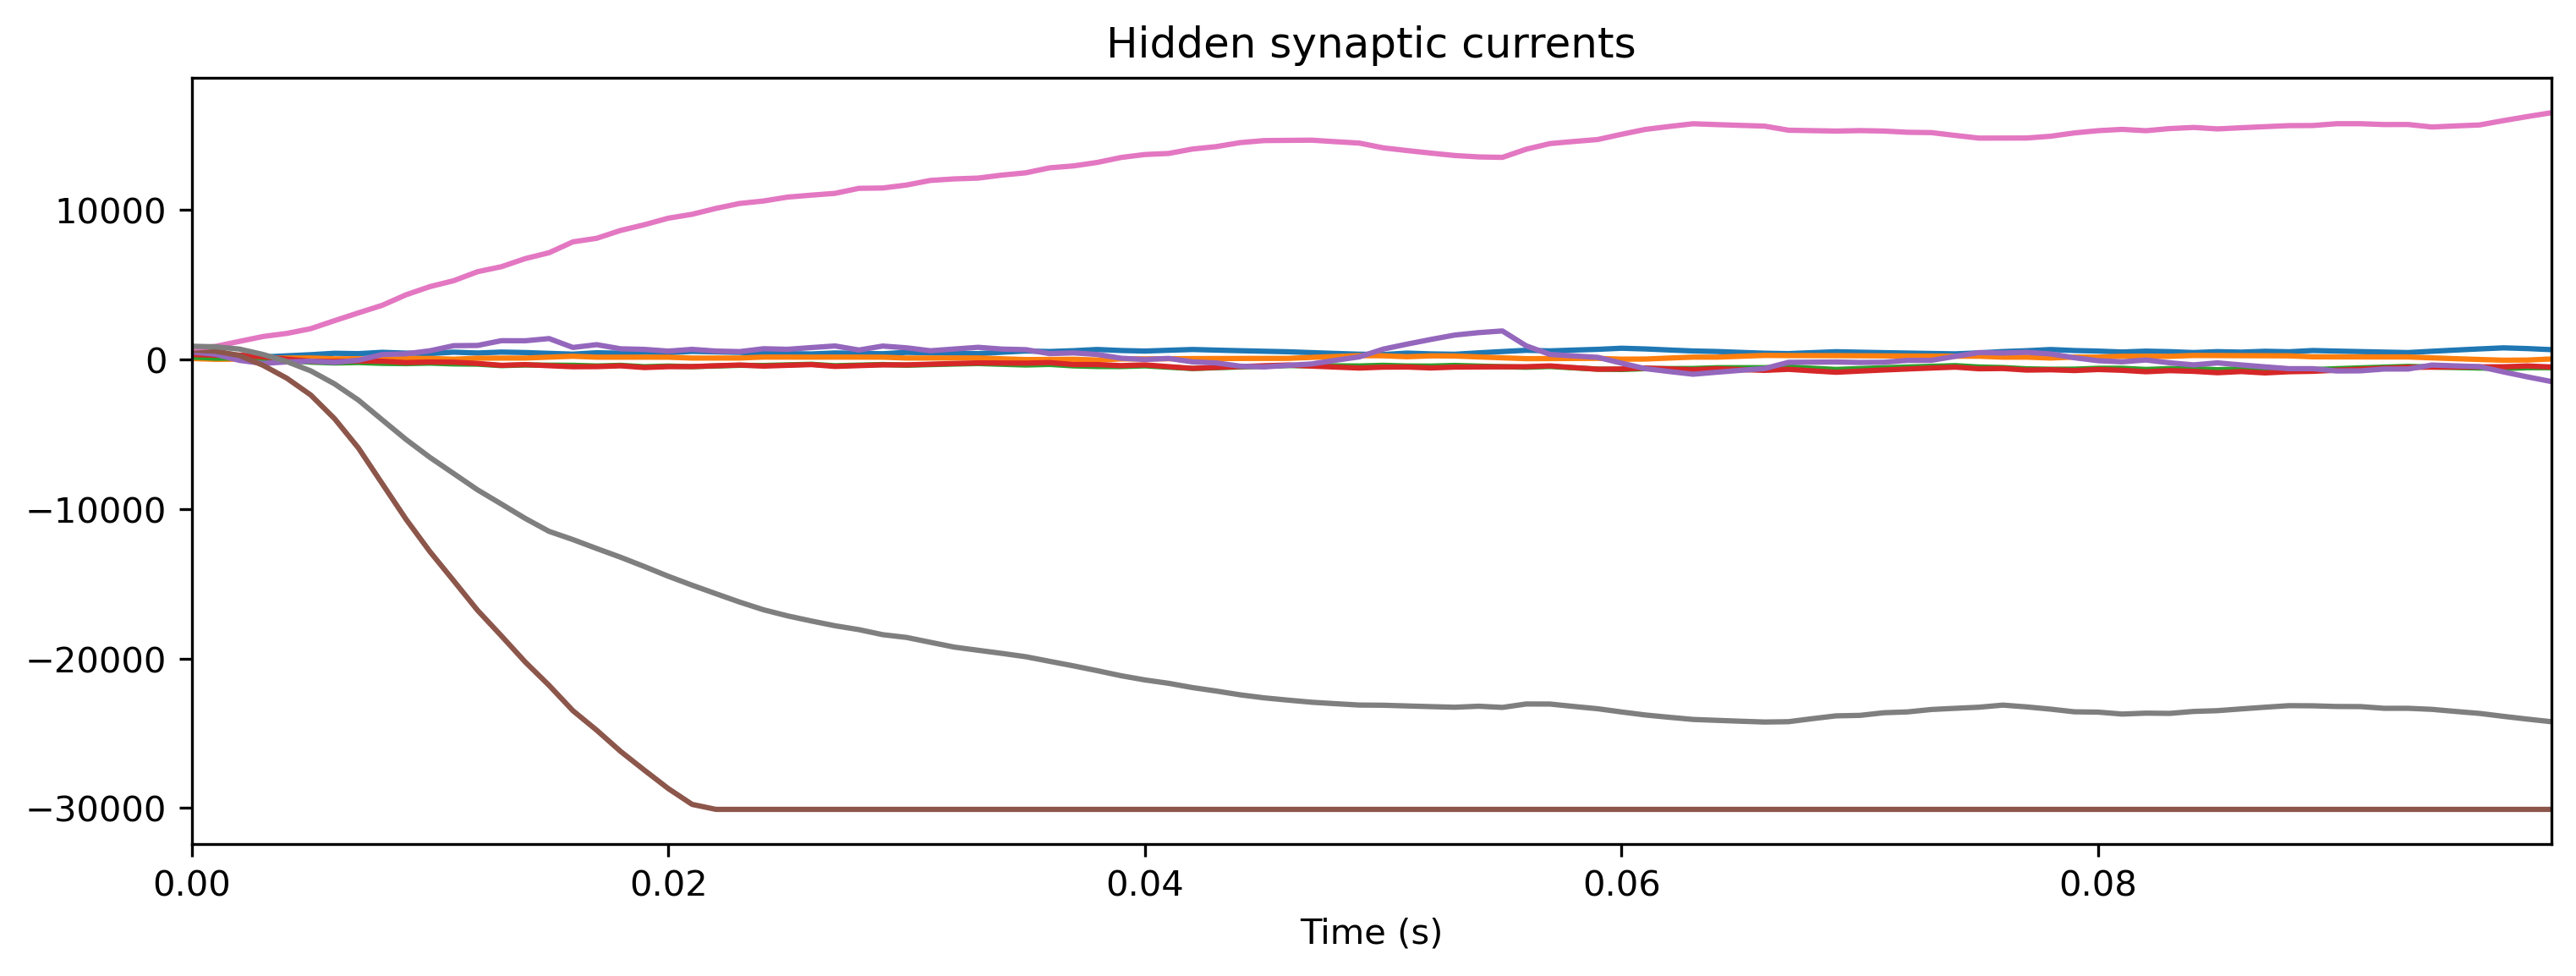

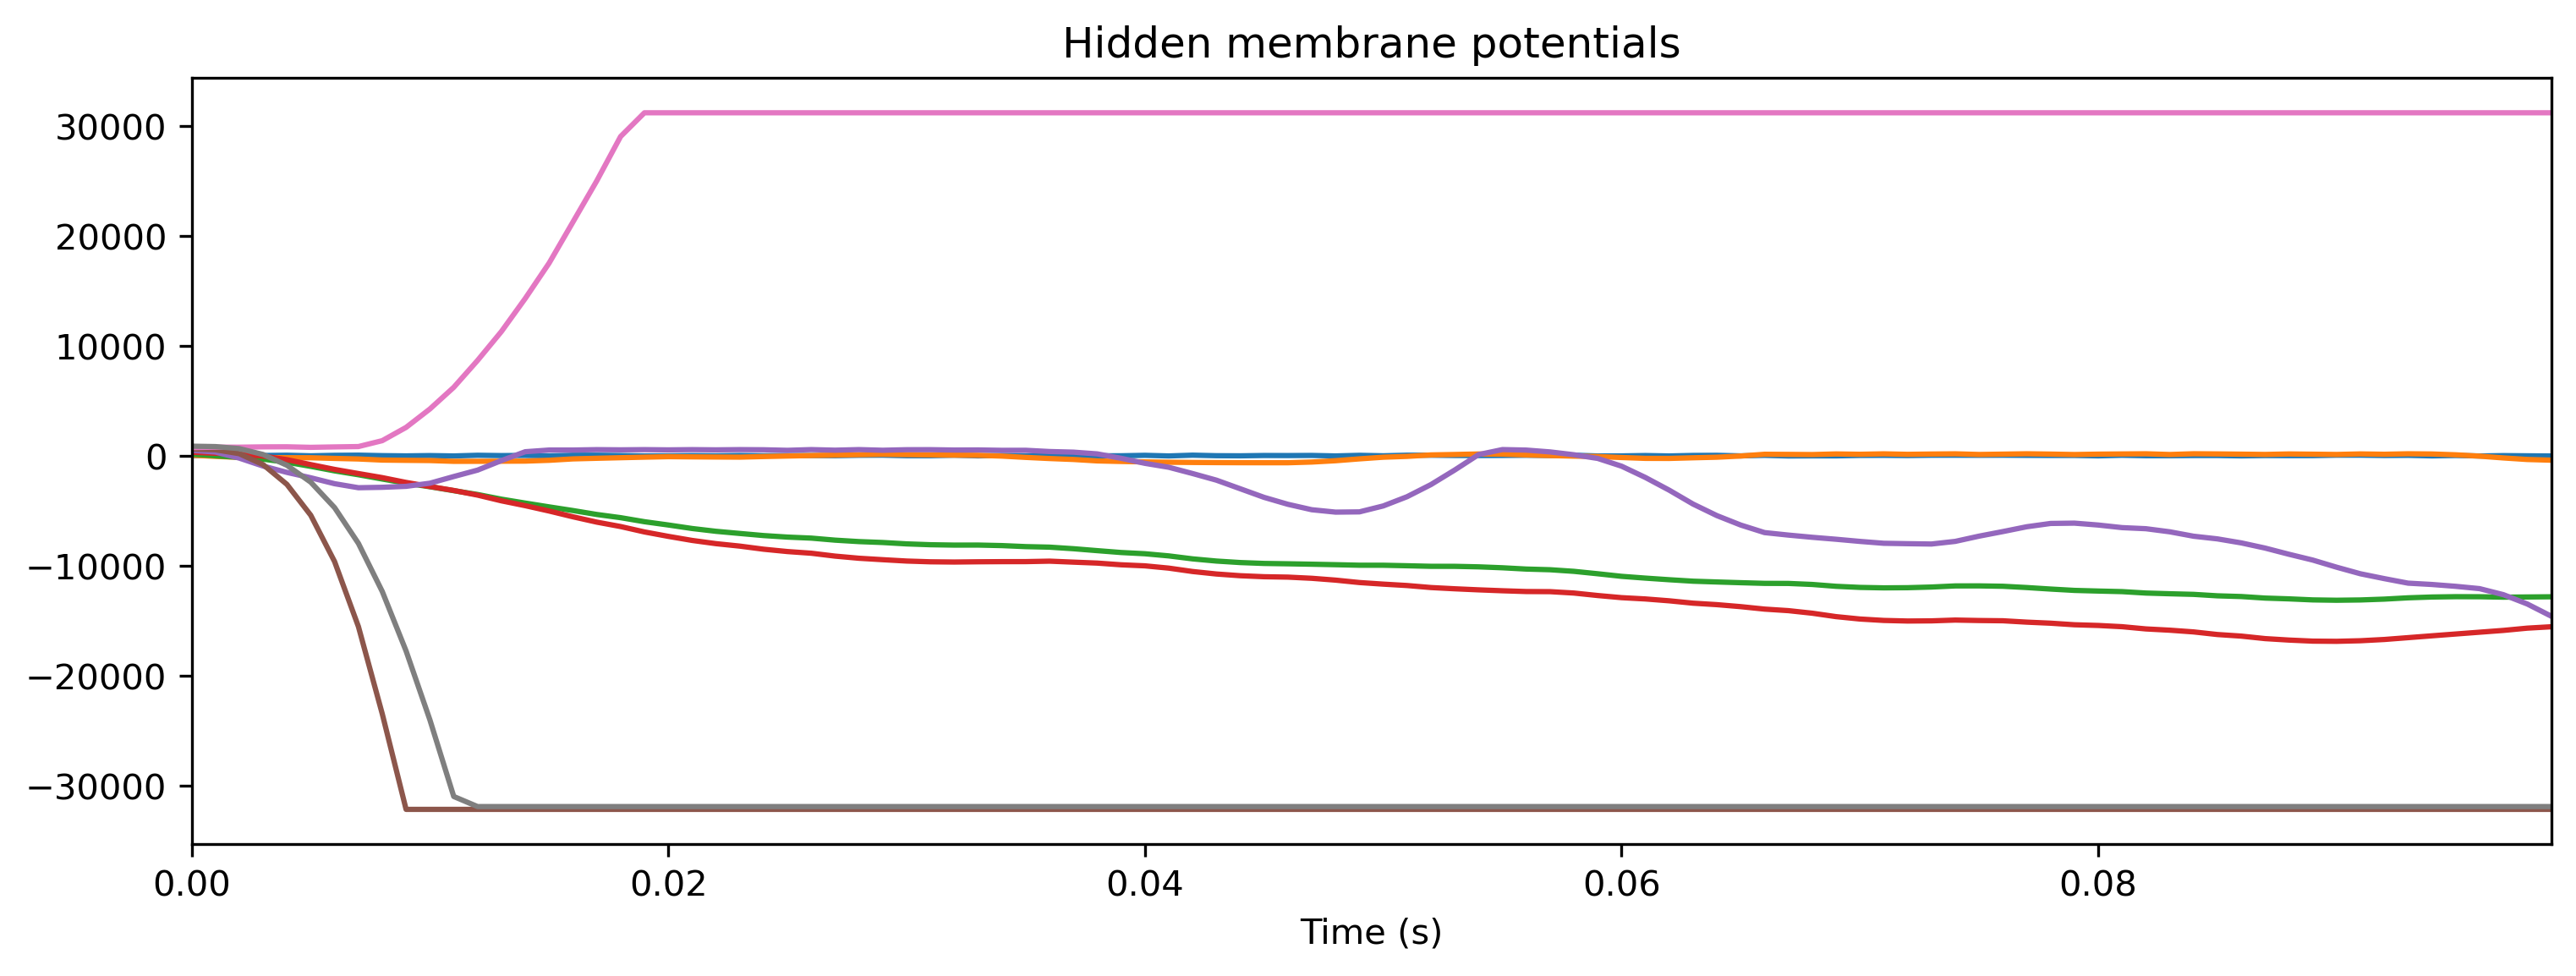

In [15]:
# - Plot some internal state variables
plt.figure()
plt.imshow(r_d['Spikes'].T, aspect = 'auto', origin = 'lower')
plt.title('Hidden spikes')
plt.ylabel('Channel')

plt.figure()
TSContinuous.from_clocked(r_d['Isyn'], dt, name = 'Hidden synaptic currents').plot(stagger = 127);

plt.figure()
TSContinuous.from_clocked(r_d['Vmem'], dt, name = 'Hidden membrane potentials').plot(stagger = 127);

## Part II: Using the XyloAudio audio front-end interface

> **_Note:_** Audio front-end is only available in Xylo™Audio 2. This step does not applied to Xylo™Audio 3.

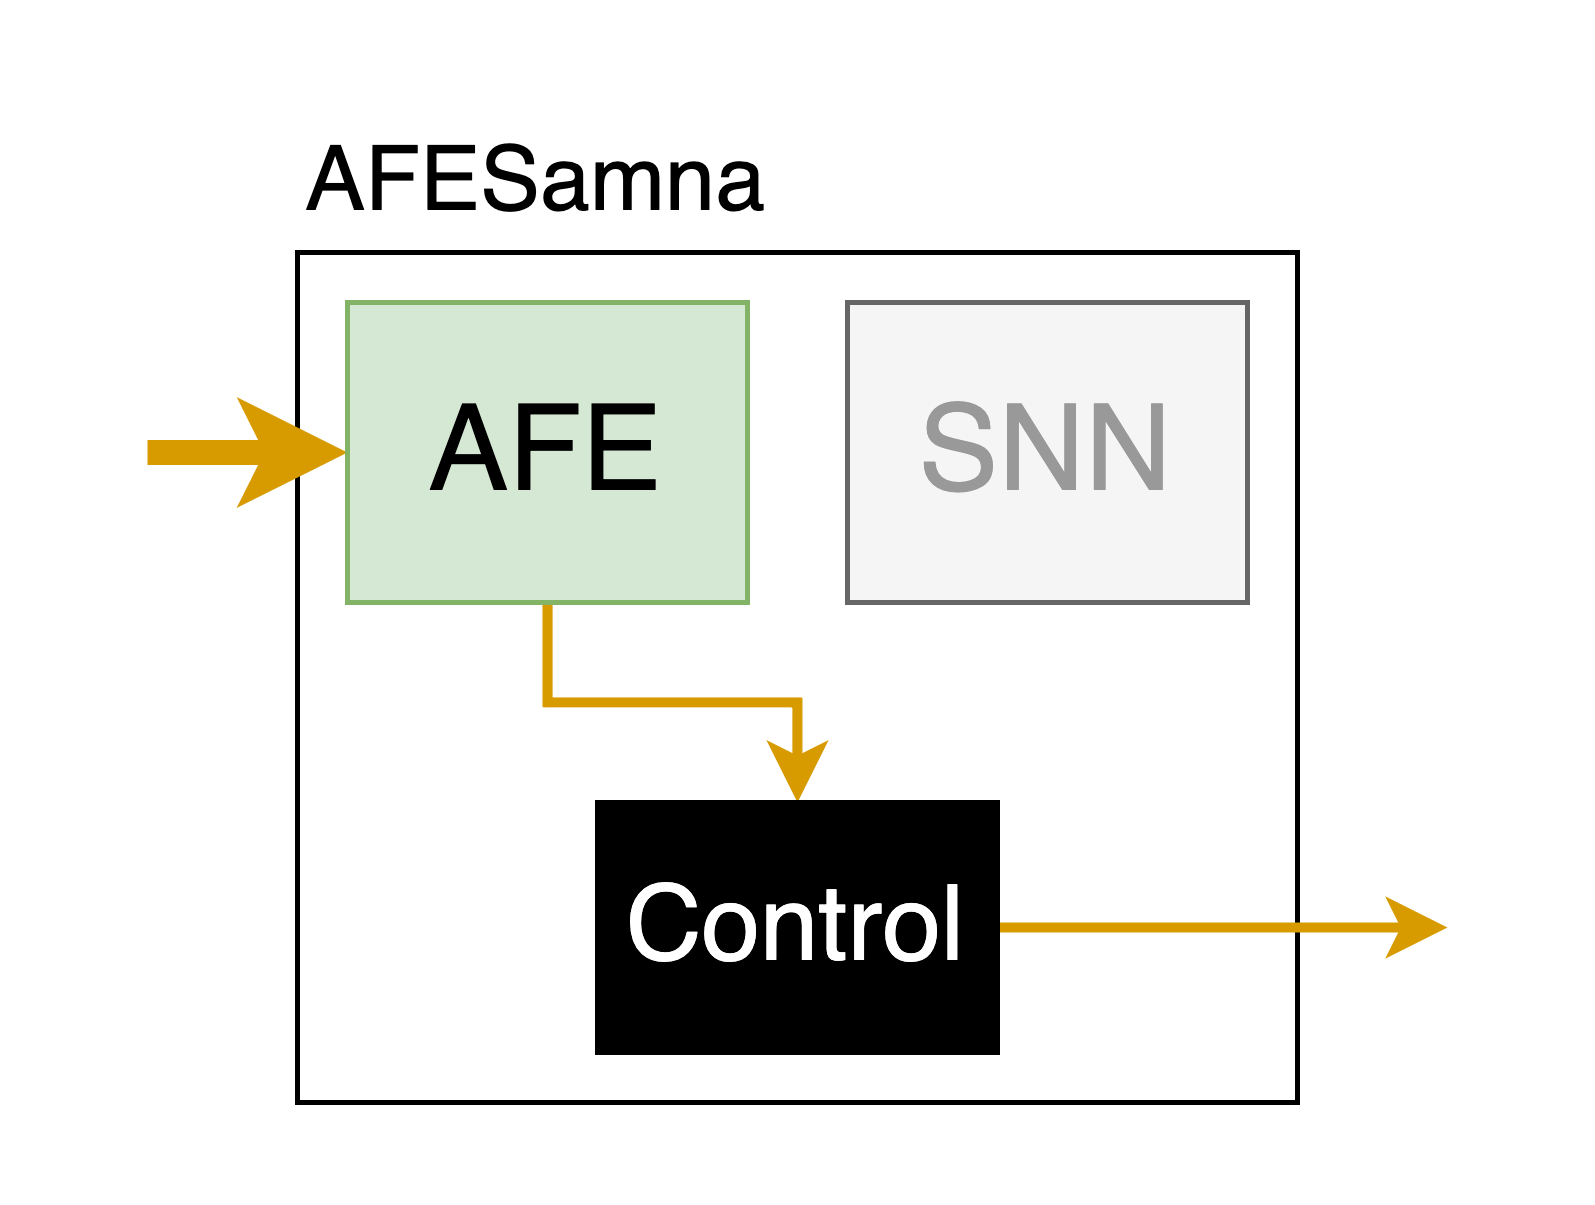

In [16]:
Image('AFESamna.png', width=400)

In [17]:
# - Find and connect to a XyloAudio HDK
from rockpool.devices.xylo import find_xylo_hdks
xylo_hdk_nodes, modules, versions = find_xylo_hdks()
print(versions)

hdk = None

for version, xylo in zip(versions, xylo_hdk_nodes):
    if version == "syns61201":
        hdk = xylo

if hdk is None:
    assert False, 'This tutorial requires a connected XyloAudio HDK to demonstrate.'


The connected Xylo HDK contains a Xylo Audio v2 (SYNS61201). Importing `rockpool.devices.xylo.syns61201`


[<samna.xyloA2TestBoard.XyloA2TestBoard object at 0x299255bf0>]

In [18]:
# - Set the time resolution and duration to record encoded audio
dt = 10e-3
timesteps = 1000

In [19]:
# - Create an AFESamna module, which wraps the AFE on the Xylo A2 HDK
#   (stay quiet while this cell is executing)
mod = xa2.AFESamna(hdk, None, dt=dt, auto_calibrate=True, amplify_level='low', hibernation_mode=False)
print(mod)

Configuring AFE...
Configured AFE


AFESamna  with shape (0, 16)

In [ ]:
# - Evolve the module to record encoded real-time audio as events
spikes_ts, _, _ = mod(np.zeros([0, timesteps, 0]))

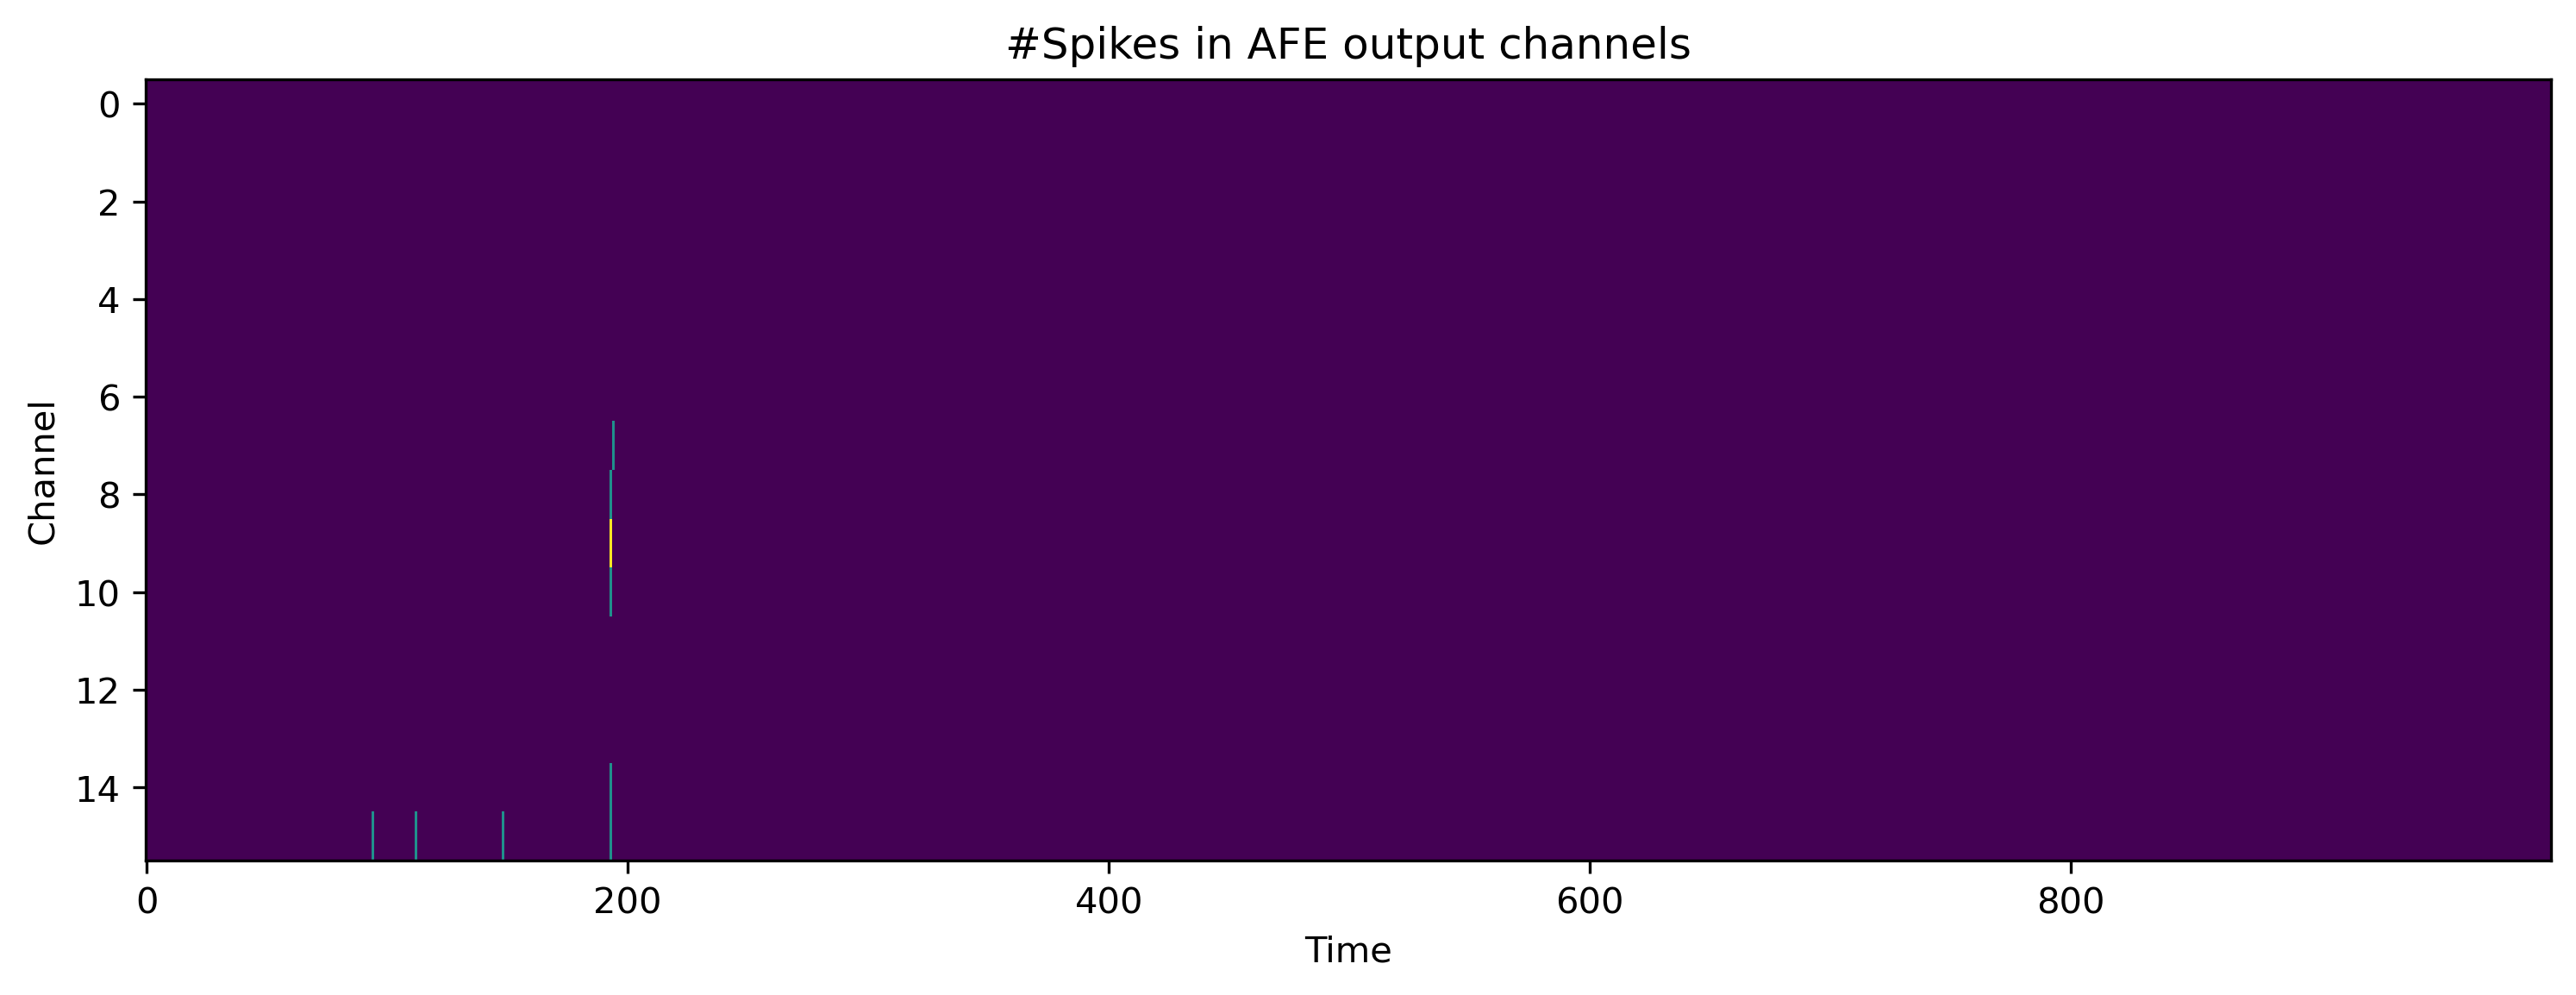

In [20]:
# - Plot some encoded audio events recorded from the AFE
plt.imshow(spikes_ts.T, aspect='auto', interpolation='none')
plt.title('#Spikes in AFE output channels')
plt.xlabel('Time')
plt.ylabel('Channel')
plt.show()


## Part III: Deploying the AFE and SNN cores in free-running inference mode

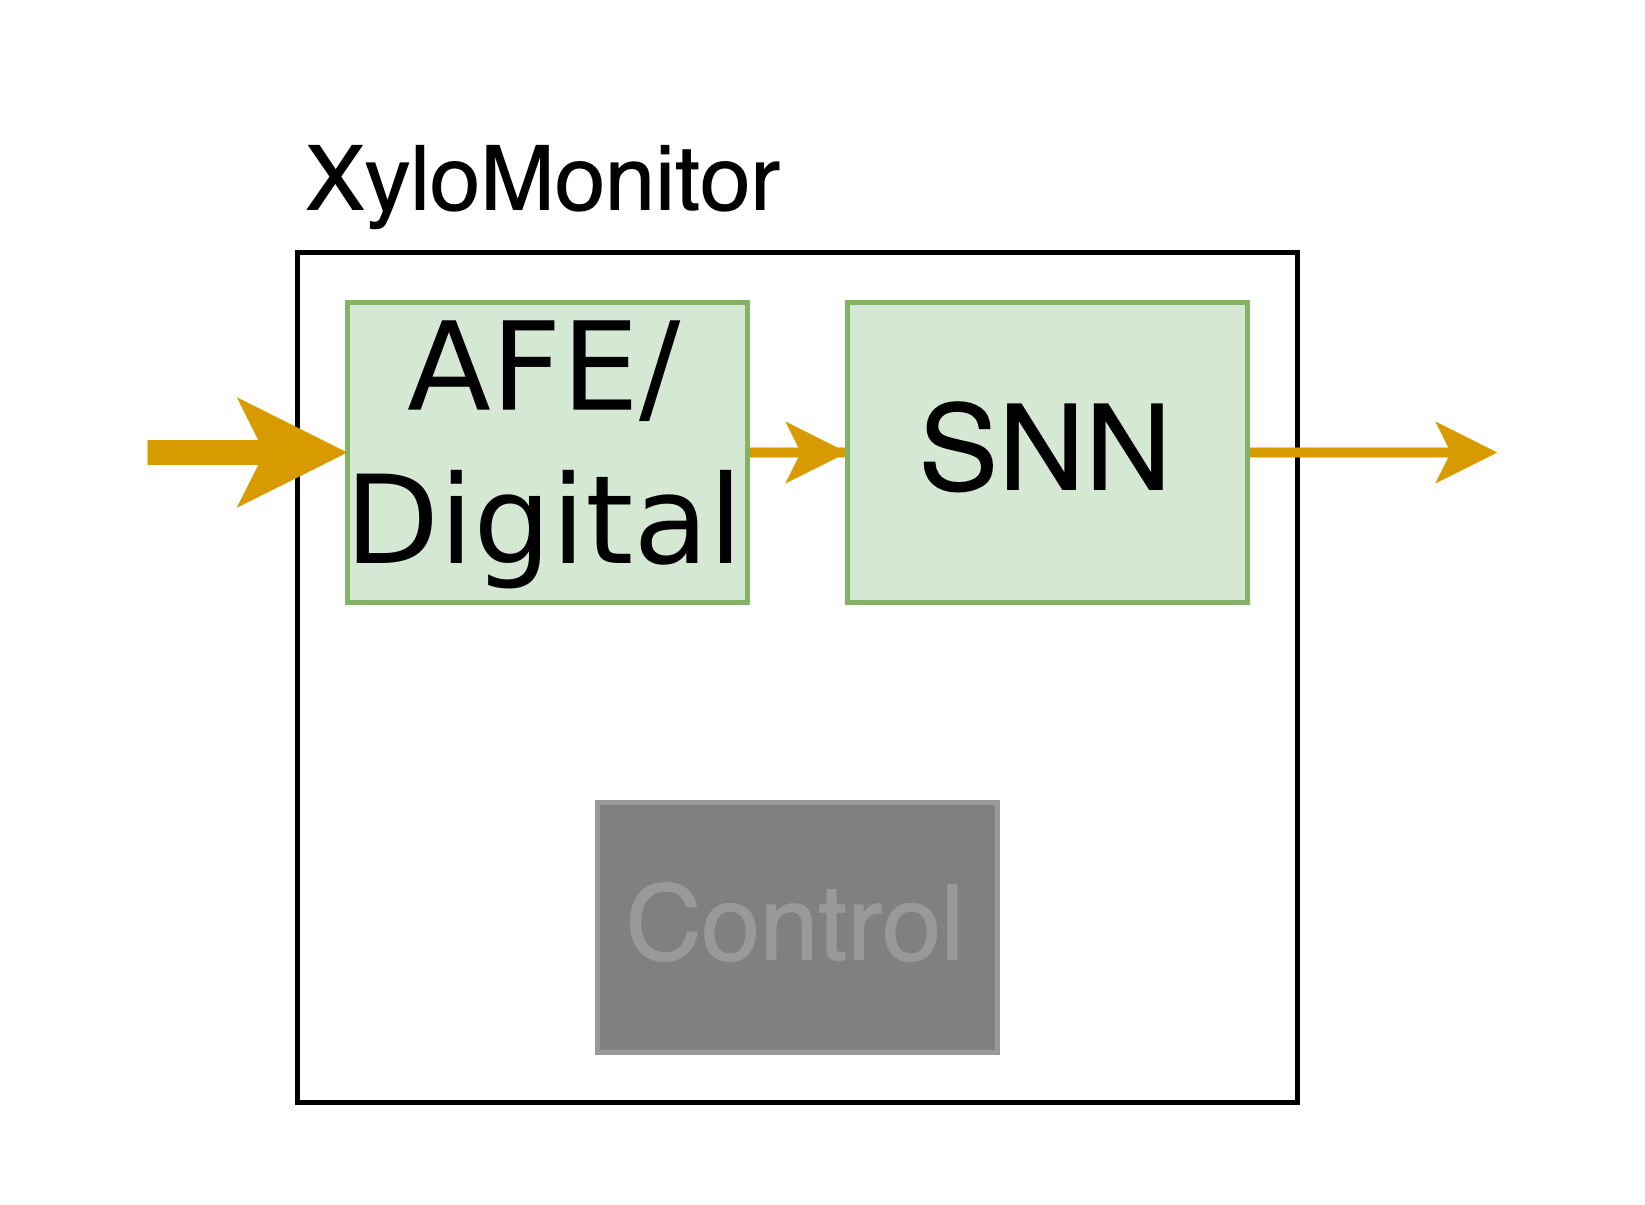

In [9]:
Image('XyloMonitor.png', width=400)

In [22]:
# - Find and connect to a XyloAudio HDK
xylo_hdk_nodes, modules, versions = find_xylo_hdks()
print(xylo_hdk_nodes)

hdk = None

for version, xylo in zip(versions, xylo_hdk_nodes):
    if version == "syns61201":
        hdk = xylo
    # - For XyloAudio 3
    # if version == "syns65302":
    #     hdk = xylo

if hdk is None:
    assert False, 'This tutorial requires a connected XyloAudio HDK to demonstrate.'


The connected Xylo HDK contains a Xylo Audio v2 (SYNS61201). Importing `rockpool.devices.xylo.syns61201`


[<samna.xyloA2TestBoard.XyloA2TestBoard object at 0x299255bf0>]

In [23]:
# - Use XyloMonitor to deploy to the HDK
# - For XyloAudio 2 you need to wait 45s until the AFE auto-calibration is done

output_mode = "Vmem"
amplify_level = "low"
hibernation = False
DN = False
T = 10

# - For XyloAudio 2
modMonitor = xa2.XyloMonitor(hdk, config, dt=dt, output_mode=output_mode, amplify_level=amplify_level, hibernation_mode=hibernation, divisive_norm=DN)
# - For XyloAudio 3
# - XyloAudio 3 does not have the amplify_level parameter and does not do AFE auto-calibration
# modMonitor = xa3.XyloMonitor(hdk, config, dt = dt, output_mode=output_mode, hibernation_mode=hibernation, dn_active=DN)


Configuring AFE...
Configured AFE


In [24]:
# - A resultList stack to store the results

class ResultList(object):
    def __init__(self, max_len=100):
        self._list = []
        self.max_len = max_len

    def reset(self):
        self._list = []

    def append(self, num):
        if len(self._list) < self.max_len:
            self._list.append(num)
        else:
            self._list[: self.max_len - 1] = self._list[1:]
            self._list[self.max_len - 1] = num

    def is_full(self):
        if len(self._list) == self.max_len:
            return True
        else:
            return False

    def counts(self, features=[]):
        count = 0
        for _ in self._list:
            if _ in features:
                count += 1
        return count

    def __len__(self):
        return len(self._list)

    def print_result(self):
        return self._list



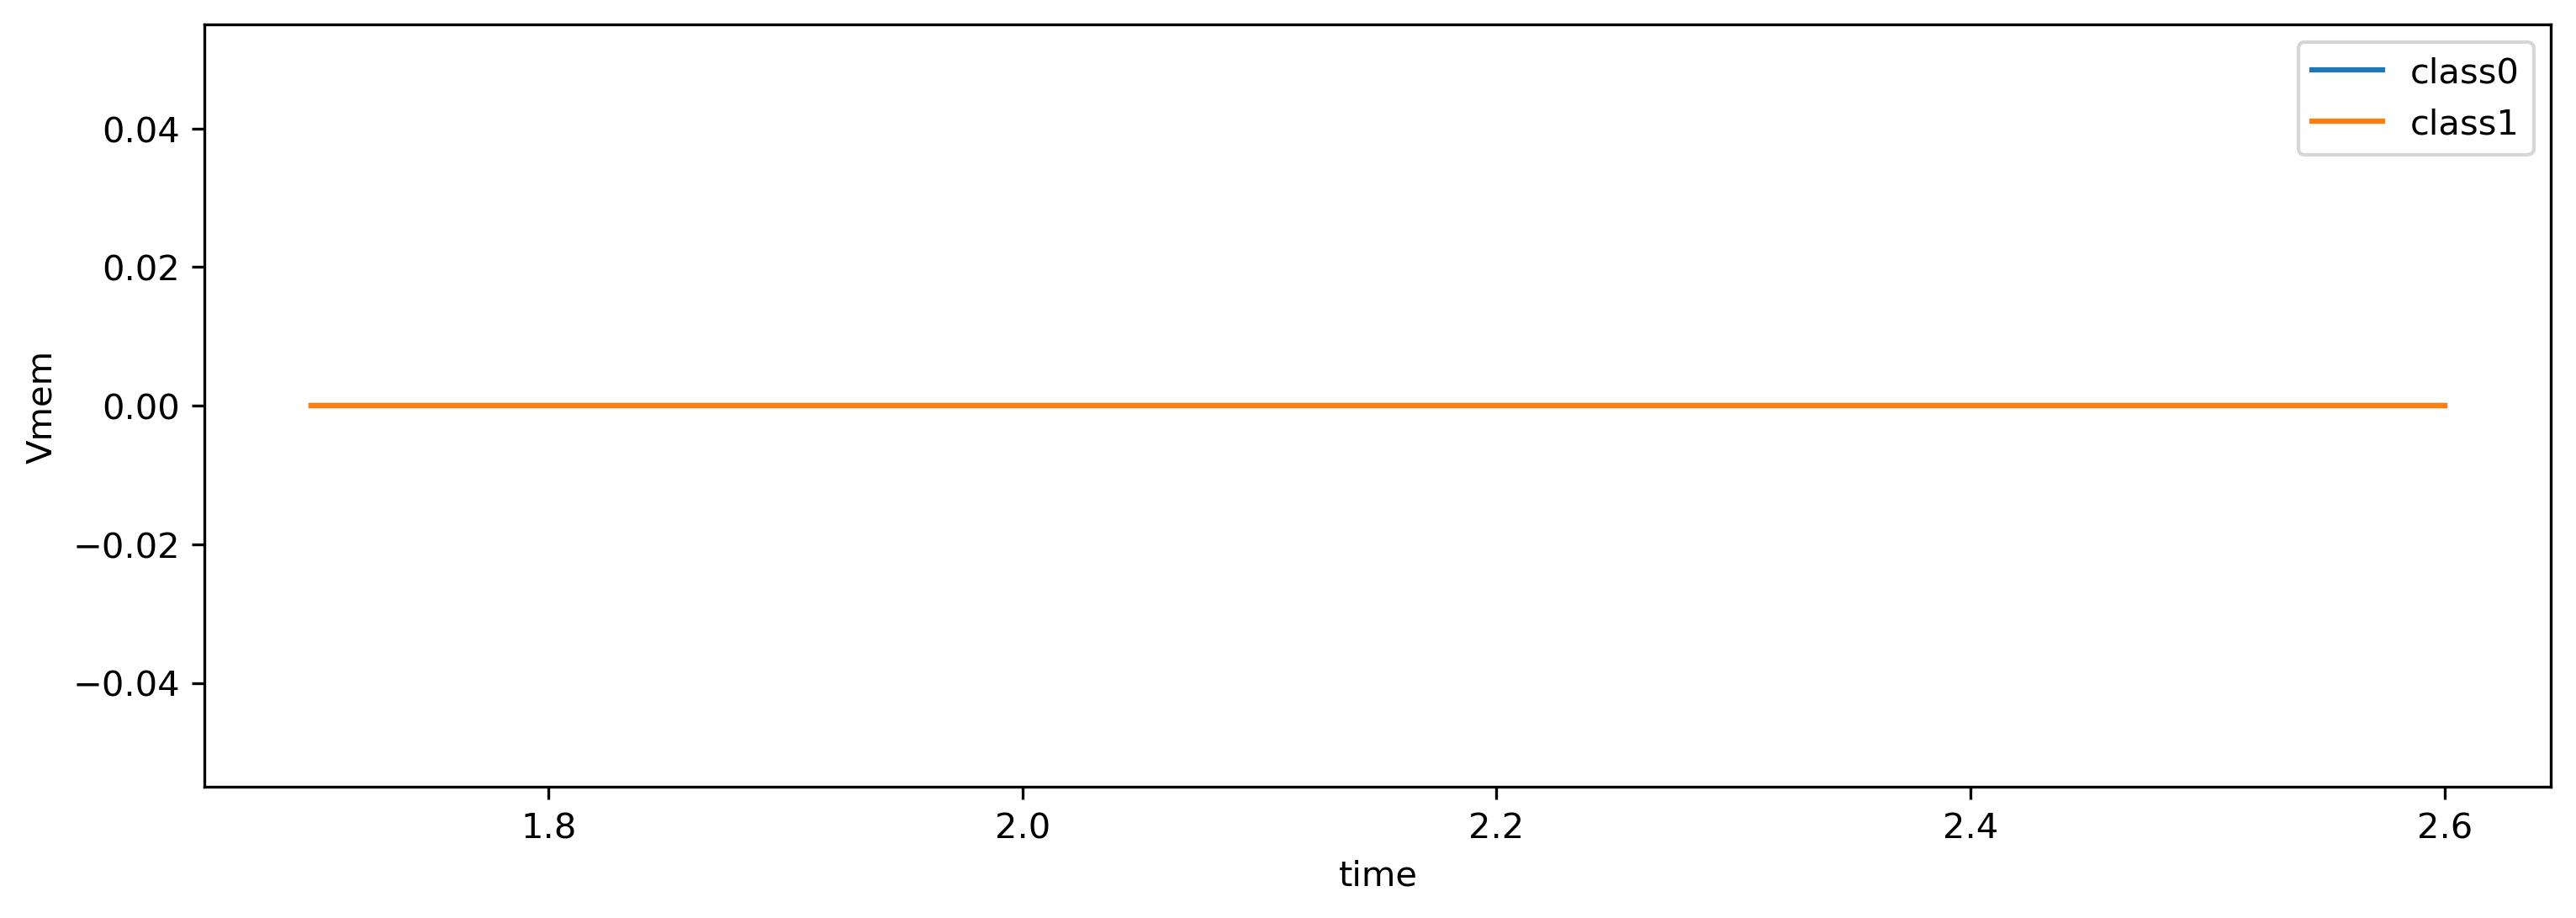

In [25]:
# - Draw a real time image for output channels
lines = [ResultList(max_len=10) for _ in range(Nout)]
time_base = ResultList(max_len=10)
tt = 0
t_inference = 10.


from time import time

t_start = time()

while (time() - t_start) < t_inference:
    # - Perform inference on the Xylo A2 HDK
    output, _, _ = modMonitor(input_data=np.zeros((T, Nin)))
    if output is not None:
        output = np.max(output, axis=0)
        for i in range(Nout):
            lines[i].append(output[i])

        time_base.append(tt)
        tt += 0.1
        ax_time = time_base.print_result()
        
        for i in range(Nout):
            plt.plot(ax_time, lines[i].print_result(), label=f"class{i}")

        plt.xlabel('time')
        plt.ylabel('Vmem')
        plt.legend()
        plt.pause(0.1)
        display.clear_output(wait=True)

## Part IV: Measuring power on the XyloAudio HDK

In [27]:
# - Find and connect to a XyloAudio HDK
xylo_hdk_nodes, modules, versions = find_xylo_hdks()
print(xylo_hdk_nodes)

hdk = None

for version, xylo in zip(versions, xylo_hdk_nodes):
    if version == "syns61201":
        hdk = xylo
    # - For XyloAudio 3
    # if version == "syns65302":
    #     hdk = xylo

if hdk is None:
    assert False, 'This tutorial requires a connected XyloAudio HDK to demonstrate.'


The connected Xylo HDK contains a Xylo Audio v2 (SYNS61201). Importing `rockpool.devices.xylo.syns61201`


[<samna.xyloA2TestBoard.XyloA2TestBoard object at 0x299255bf0>]

In [35]:
# - Set a low clock frequency for the XyloAudio 2 device
# - This step is not necessary for XyloAudio 3
xa2utils.set_xylo_core_clock_freq(hdk, 6.25)

# - Use XyloSamna to deploy to the HDK
# - For XyloAudio 2
modSamna = xa2.XyloSamna(hdk, config, dt = 10e-3, power_frequency=20.)
# - For XyloAudio 3
# modSamna = xa3.XyloSamna(hdk, config, dt = 10e-3, power_frequency=20.)
print(modSamna)

XyloSamna  with shape (2, 8, 2)

In [38]:
# - Generate some Poisson input
T = 1000
f = 0.4
input_spikes = np.random.rand(T, Nin) < f

# - Evolve some input on the SNN core, and record power during inference
out, _, record_dict = modSamna(input_spikes, record_power = True)

print(record_dict)

{
    'io_power': array([0.00010319, 0.00010395, 0.000103  , 0.00010395, 0.00010529,
       0.00010319]),
    'logic_afe_power': array([1.07421875e-05, 1.22528076e-05, 9.56726074e-06, 1.09100342e-05,
       1.07421875e-05, 9.90295410e-06]),
    'io_afe_power': array([8.96453857e-06, 6.29425049e-06, 8.20159912e-06, 6.48498535e-06,
       9.72747803e-06, 7.43865967e-06]),
    'logic_power': array([0.00027166, 0.00027309, 0.00027233, 0.00026931, 0.00027107,
       0.00026998])
}

In [44]:
# - Measure idle power (no evolution)
from time import sleep
import samna

modSamna._power_buf.get_events()
sleep(5.)
power = modSamna._power_buf.get_events()

power_idle = ([], [], [], [])

for p in power:
    power_idle[p.channel].append(p.value)

idle_power_per_channel = np.mean(np.stack(power_idle), axis = 1)

# - For XyloAudio 2
channels = samna.xyloA2TestBoard.MeasurementChannels
io_power = idle_power_per_channel[channels.Io]
afe_core_power = idle_power_per_channel[channels.LogicAfe]
afe_ldo_power = idle_power_per_channel[channels.IoAfe]
snn_core_power = idle_power_per_channel[channels.Logic]

# - For XyloAudio 3
# io_power = idle_power_per_channel[0] 
# analog_power = idle_power_per_channel[1] 
# digital_power = idle_power_per_channel[2]


print(f'XyloAudio 2\nAll IO:\t\t{io_power * 1e6:.1f} µW\nAFE core:\t{afe_core_power * 1e6:.1f} µW\nInternal LDO:\t{afe_ldo_power * 1e6:.1f} µW\nSNN core logic:\t{snn_core_power*1e6:.1f} µW')
print(f'XyloAudio 3\nAll IO:\t\t{io_power * 1e6:.1f} µW\nAFE core:\t{afe_core_power * 1e6:.1f} µW\nSNN core logic:\t{snn_core_power*1e6:.1f} µW')

All IO:         99.84207153320312µW
AFE analog:     10.385513305664062µW
Internal LDO:   7.274627685546874µW
SNN core logic: 250.0865173339844µW

### Hints on reducing power consumption

In [ ]:
help(xa2utils.set_xylo_core_clock_freq)

Help on function set_xylo_core_clock_freq in module rockpool.devices.xylo.syns61201.xa2_devkit_utils:

set_xylo_core_clock_freq(device: Any, desired_freq_MHz: float) -> float
    Set the inference core clock frequency used by Xylo
    
    Args:
        device (XyloA2HDK): A Xylo2 device to configure
        desired_freq_MHz (float): The desired Xylo2 core clock frequency in MHz
    
    Returns:
        float: The obtained Xylo2 core clock frequency in MHz



### Estimate the required master clock frequency for real-time operation

In [6]:
from rockpool.devices.xylo.syns61201 import cycles_model, est_clock_freq

help(cycles_model)

Help on function cycles_model in module rockpool.devices.xylo.syns61201.power_cycles_model:

cycles_model(config: samna.xyloCore2.configuration.XyloConfiguration, input_sp: Union[float, numpy.ndarray, torch.Tensor, array] = 1.0, hidden_sp: Union[float, numpy.ndarray, torch.Tensor, array] = 1.0, output_sp: Union[float, numpy.ndarray, torch.Tensor, array] = 1.0) -> Tuple[float, float]
    Calculate the average number of cycles required for a given network architecture
    
    This function contains a model which estimates the number of master clock cycles required for the Xylo SNN SYNS61202 inference core to compute one time-step for a given chip configuration in ``config``. Use :py:func:`.devices.xylo.syns61201.config_from_specification`` to obtain a chip configuration, along with :py:meth:`.Module.as_graph()`` and :py:func:`.devices.xylo.syns61201.mapper`, as described in the deployment tutorials for Xylo.
    
    By default the model provides a "worst-case" estimation, assuming that

In [7]:
help(est_clock_freq)

Help on function est_clock_freq in module rockpool.devices.xylo.syns61201.power_cycles_model:

est_clock_freq(config: samna.xyloCore2.configuration.XyloConfiguration, dt: float, margin: float = 0.2)
    Estimate the required master clock frequency, to run a network in real-time
    
    This function will perform a worst-case analysis, assuming that every input channel, every hidden neuron and every output neuron fire an event on each `dt`. An additional margin is included (Default: 20%), to guarantee that the model will run in real time at the suggested master clock frequency.
    
    Args:
        config (XyloA2Config):  A Xylo Audio 2 configuration for which to estimate the required clock frequency
        dt (float): The required network `dt`, in seconds
        margin (float): The additional overhead safety margin to add to the estimation, as a fraction. Default: `0.2` (20%)



In [ ]:
print(f"This network requires {cycles_model(config)} master clock cycles per network time-step.")
print(f"This network requires a master clock of {est_clock_freq(config, dt) / 1e6:.2f} MHz for real-time operation.")